In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import cmath
from numba import njit, f8,i8,c16
import numba
import copy
import matplotlib
#import banpei
import concurrent
import func_for_paralell

import sys
sys.path.append('../../lb')
import RungeKutta_acceralated


#パラメーター
nu = 0.001

f = (1 + 1j) * 5 * 0.001

Dimention = 14 #uの次元数
q = 2
k_0 = 2 ** (-4)
k_n = np.zeros((Dimention+4,1))
k_n[2:-2,0] = [k_0 * q ** (i+1) for i in range(Dimention)]
#print(k_n)

c_n_1 = copy.deepcopy(k_n)[2:-2, 0:]
c_n_1[-2:, 0:] = np.zeros((2,1))
#print(c_n_1)

beta = 0.5
c_n_2 = copy.deepcopy(k_n)[1:-3, 0:] * -beta
c_n_2[-1, 0] = np.zeros((1, 1))
#print(c_n_2)

c_n_3 = copy.deepcopy(k_n)[:-4, 0:] * (beta - 1)
#print(c_n_3)

#parameter = [nu,f,k_n,c_n_1,c_n_2,c_n_3]
parameter = {
    'nu' : nu,
    'f' : f,
    'k_n' : k_n,
    'c_n_1' : c_n_1,
    'c_n_2' : c_n_2,
    'c_n_3' : c_n_3
}
#print(parameter)
#print(k_n)

runge_para = {
    'start' :  np.array([
        [0.4350E+00 + 0.5008E+00j],
        [0.1259E+00 + 0.2437E+00j],
        [-0.8312E-01 + -0.4802E-01j],
        [0.5164E-01 + -0.1599E+00j],
        [-0.1899E+00 + -0.3602E-01j],
        [0.4093E-03 + 0.8506E-01j],
        [0.9539E-01 + 0.3215E-01j],
        [-0.5834E-01 + 0.4433E-01j],
        [-0.8790E-02 + 0.2502E-01j],
        [0.3385E-02 + 0.1148E-02j],
        [-0.7072E-04 + 0.5598E-04j],
        [-0.5238E-07 + 0.1467E-06j],
        [0.1E-07 + 0.1E-06j],
        [0.1E-07 + 0.1E-06j]
    ]),
    'step' : 0.01,
    'period' : (0,5000),
    'nu' : nu,
    'f' : f,
    'k_n' : k_n,
    'c_n_1' : c_n_1,
    'c_n_2' : c_n_2,
    'c_n_3' : c_n_3
}

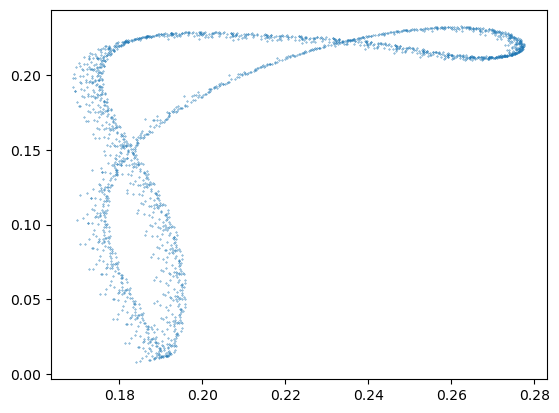

In [41]:
laminar = np.load("/Users/hibiki/Downloads/beta0.46711_nu0.00011871562745803017_step0.01_3000check_500pro_20000period.npz")["laminar"][:,::50]
laminar = laminar[:-1,:laminar.shape[1]//20]
plt.scatter(np.abs(laminar[3,:]),np.abs(laminar[4,:]),s=0.1)

In [44]:
%%time
skip = 2000
runge_para["period"]=(0,100000000)
#runge_para['start'] = np.load("../laminar_initials/beta0.423_nu0.00017584784643038092_step0.01_1500check_500pro_20000period.npz")["start"]
runge_para["nu"] = 0.00017256
beta= 0.418

#c_n_2
runge_para["c_n_2"] = runge_para["k_n"][1:-3, 0:] * -beta
runge_para["c_n_2"][-1, 0:] = np.zeros((1, 1))

#c_n_3
runge_para["c_n_3"] = runge_para["k_n"][:-4, 0:] * (beta - 1)

error = 1E-1

with concurrent.futures.ProcessPoolExecutor(max_workers = 8) as executor: 
    task1 = executor.submit(func_for_paralell.laminar_distribution, runge_para, laminar, skip, error)
    task2 = executor.submit(func_for_paralell.laminar_distribution, runge_para, laminar, skip, error)
    task3 = executor.submit(func_for_paralell.laminar_distribution, runge_para, laminar, skip, error)


    times1 = task1.result()
    times2 = task2.result()
    times3 = task3.result()

times = np.concatenate([times1, times2, times3])

CPU times: user 236 ms, sys: 148 ms, total: 384 ms
Wall time: 7h 31min 49s


In [10]:
sorted = np.load('../distribution/laminar_time_distribution_beta=0.423_nu=0.00017584784643038092_0.01step_10skip.npz')["times"]

In [45]:
sorted = np.sort(times)

In [11]:
add = np.load('../distribution/laminar_time_distribution_beta=0.423_nu=0.00017584784643038092_0.01step100000000period1000skip_epsilon0.01.npz')["times"]

In [9]:
np.savez_compressed(f"../distribution/laminar_time_distribution_beta={beta}_nu={runge_para['nu']}_{runge_para['step']}step{runge_para['period'][1]}period{skip}skip_epsilon{error}.npz", times=sorted)

In [13]:
sorted = np.concatenate((sorted, add))

In [ ]:
sorted = np.load('../cpp/')

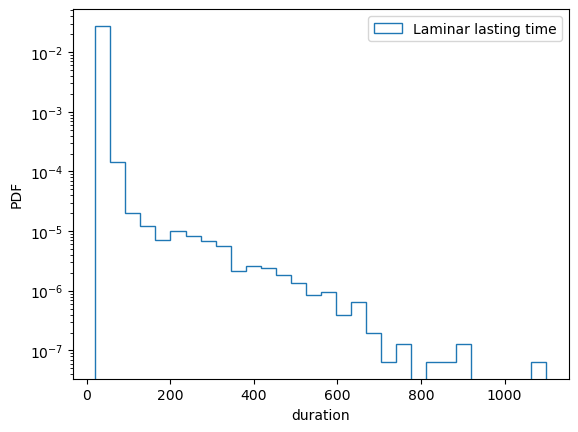

In [47]:
from scipy.stats import pareto, expon
#ヒストグラム
fig, ax = plt.subplots()
loglog = False
#ax.set_title("Distribution of time in laminar state")
ax.set_ylabel("PDF")
ax.set_xlabel("duration")
# x軸の範囲を設定
x = np.linspace(50, 1500, 100)

# pareto分布のパラメータを設定
b = 2.5# 形状パラメータ
m = 50 # 最小値
# 指数分布のパラメータを設定
lam = 0.0075

"""
# PDFをプロット
ax.plot(x, pareto.pdf(x, b, scale=m), 'r-', lw=2, alpha=0.5, label='Pareto')
# PDFをプロット
plt.plot(x, expon.pdf(x, scale=1/lam), 'g', lw=2, alpha=0.6, label='Exponential')
"""

if loglog:
    ax.set_xscale("log")
ax.set_yscale("log")

ax.hist(sorted,bins=30,density=True,histtype="step",label="Laminar lasting time")
ax.legend()
# if loglog:
#     fig.savefig(f"../distribution/laminar_time_distribution(loglog)_beta={beta}_nu={runge_para['nu']}_{runge_para['step']}step_{runge_para['period'][1]}period_{skip}_epsilon{error}skip.jpg")
# else:
#     fig.savefig(f"../distribution/laminar_time_distribution(semilog)_beta={beta}_nu={runge_para['nu']}_{runge_para['step']}step_{runge_para['period'][1]}period_{skip}_epsilon{error}skip.jpg")

In [15]:
np.load("../distribution/laminar_time_distribution_beta=0.423_nu=0.00017584784643038092_0.01step1000000000period2000skip_epsilon0.1.npz")["times"].shape

(25119141,)

In [53]:
runge_para["period"]=(0,100000)
runge_para['start'] = np.load("/Users/hibiki/Downloads/beta0.46711_nu0.00011871562745803017_step0.01_3000check_500pro_20000period.npz")["laminar"][:-1,:1]
runge_para["nu"] = 0.00011871562745803017
beta= 0.46711

#c_n_2
runge_para["c_n_2"] = runge_para["k_n"][1:-3, 0:] * -beta
runge_para["c_n_2"][-1, 0:] = np.zeros((1, 1))

#c_n_3
runge_para["c_n_3"] = runge_para["k_n"][:-4, 0:] * (beta - 1)
model = RungeKutta_acceralated.RungeKutta()
model.get_arr_latter(**runge_para, latter=1)

In [54]:
%%time
skip = 1
epsilon = 7E-2
lmodel = RungeKutta_acceralated.Long_laminar()
arr1 = model.arr_latter[:-1, :model.arr_latter.shape[1]//4]
arr2 = model.arr_latter[:-1, model.arr_latter.shape[1]//4:model.arr_latter.shape[1]//2]
arr3 = model.arr_latter[:-1, model.arr_latter.shape[1]//2:model.arr_latter.shape[1]//4*3]
arr4 = model.arr_latter[:-1, model.arr_latter.shape[1]//4*3:]


with concurrent.futures.ProcessPoolExecutor(max_workers = 8) as executor: 
    task1 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr1, skip, epsilon)
    task2 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr2, skip, epsilon)
    task3 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr3, skip, epsilon)
    task4 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr4, skip, epsilon)

    times1 = task1.result()
    times2 = task2.result()
    times3 = task3.result()
    times4 = task4.result()
        
times = np.concatenate([times1, times2, times3, times4], axis=1)

CPU times: user 683 ms, sys: 1.04 s, total: 1.72 s
Wall time: 1min 34s


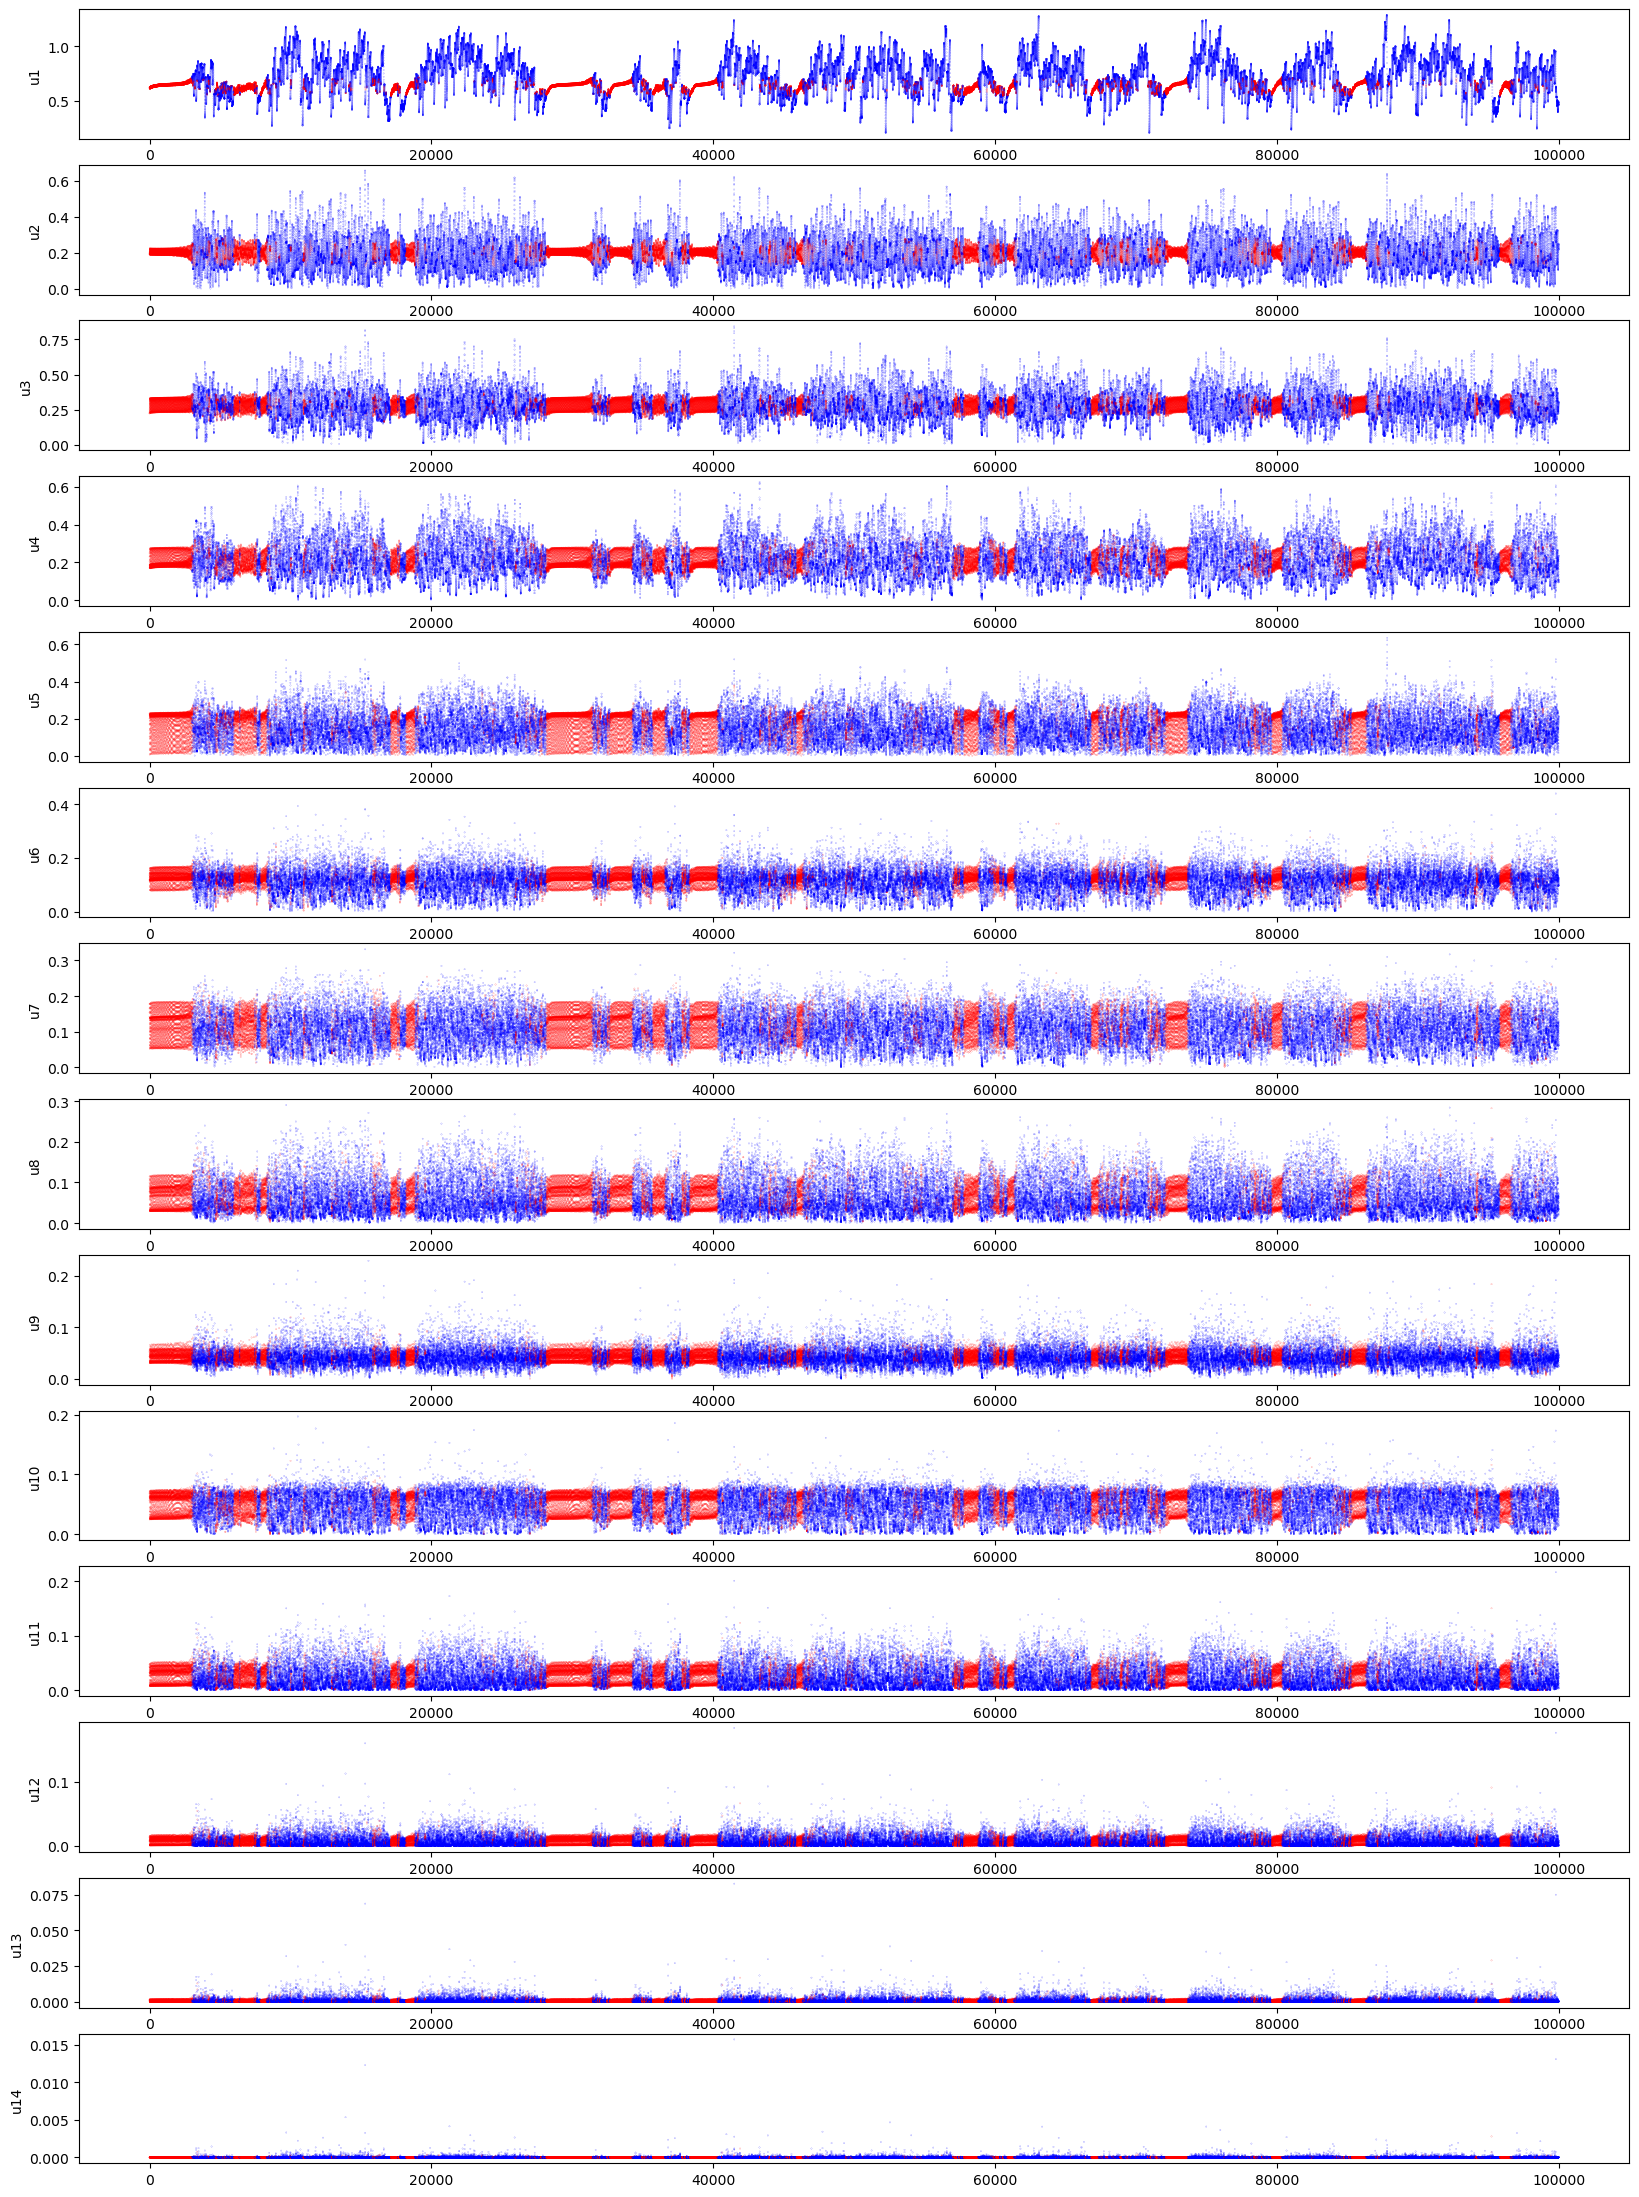

In [55]:
# 条件に応じてプロットする点の色を決定する
colors = ['red' if x > 0.5 else 'blue' for x in times[0,::100].tolist()]
plt.figure(figsize=(20,30))
for i in range(Dimention):
    plt.subplot(Dimention+1,1,i+1)
    plt.ylabel(f"u{i+1}")
    #plt.yscale=("log")
    plt.scatter(np.real(model.arr_latter[-1,::100]),abs(model.arr_latter[i,::100]),s=0.01, color=colors)
plt.savefig(f"../distribution/identify_laminar_beta={beta}_nu={runge_para['nu']}_{runge_para['step']}step_{skip}skip_epsilon{epsilon}.jpg")

In [16]:
#extract laminar
laminar_extracted = model.arr_latter[:,np.where(times[0,:] == 1)][:,0,:].T

array = np.zeros((laminar_extracted.shape[0],laminar_extracted.shape[1]*2-1), dtype=np.float64)
array[:, 0] = np.real(laminar_extracted[:, -1])
array[:,1::2] = np.real(laminar_extracted[:,:-1])
array[:,2::2] = np.imag(laminar_extracted[:,:-1])
a = np.loadconcatenate("laminar_extracted_500,000period_beta0.423_nu0.00017584784643038092_step0.01.txt")
array = np.concatenate((a,array), axis = 0)
np.savetxt(f"laminar_extracted_{round(array[-1, 0])}period_beta0.423_nu0.00017584784643038092_step0.01.txt", array)

In [8]:
for i in range(30):
    runge_para["period"]=(500000*(i+13),500000*(i+14))
    runge_para['start'] = model.arr_latter[:-1, -1:]
    runge_para["nu"] = 0.00017584784643038092
    beta= 0.423

    #c_n_2
    runge_para["c_n_2"] = runge_para["k_n"][1:-3, 0:] * -beta
    runge_para["c_n_2"][-1, 0:] = np.zeros((1, 1))

    #c_n_3
    runge_para["c_n_3"] = runge_para["k_n"][:-4, 0:] * (beta - 1)
    model = RungeKutta_acceralated.RungeKutta()
    model.get_arr_latter(**runge_para, latter=1)

    skip = 1
    epsilon = 0.01
    lmodel = RungeKutta_acceralated.Long_laminar()
    arr1 = model.arr_latter[:-1, :model.arr_latter.shape[1]//4]
    arr2 = model.arr_latter[:-1, model.arr_latter.shape[1]//4:model.arr_latter.shape[1]//2]
    arr3 = model.arr_latter[:-1, model.arr_latter.shape[1]//2:model.arr_latter.shape[1]//4*3]
    arr4 = model.arr_latter[:-1, model.arr_latter.shape[1]//4*3:]


    with concurrent.futures.ProcessPoolExecutor(max_workers = 8) as executor: 
        task1 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr1, skip, epsilon)
        task2 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr2, skip, epsilon)
        task3 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr3, skip, epsilon)
        task4 = executor.submit(lmodel.judge_laminar_or_not, laminar, arr4, skip, epsilon)

        times1 = task1.result()
        times2 = task2.result()
        times3 = task3.result()
        times4 = task4.result()

    times = np.concatenate([times1, times2, times3, times4], axis=1)

    #extract laminar
    laminar_extracted = model.arr_latter[:,np.where(times[0,:] == 1)][:,0,:].T
    
    a = np.loadtxt(f"laminar_extracted_{500000*(i+13)}period_beta0.423_nu0.00017584784643038092_step0.01.txt")
    array = np.zeros((laminar_extracted.shape[0],laminar_extracted.shape[1]*2-1), dtype=np.float64)
    array[:, 0] = np.real(laminar_extracted[:, -1])
    array[:,1::2] = np.real(laminar_extracted[:,:-1])
    array[:,2::2] = np.imag(laminar_extracted[:,:-1])
    array = np.concatenate((a,array), axis = 0)
    np.savetxt(f"laminar_extracted_{500000*(i+14)}period_beta0.423_nu0.00017584784643038092_step0.01.txt", array)


KeyboardInterrupt



# それぞれのシェルの絶対値の分布

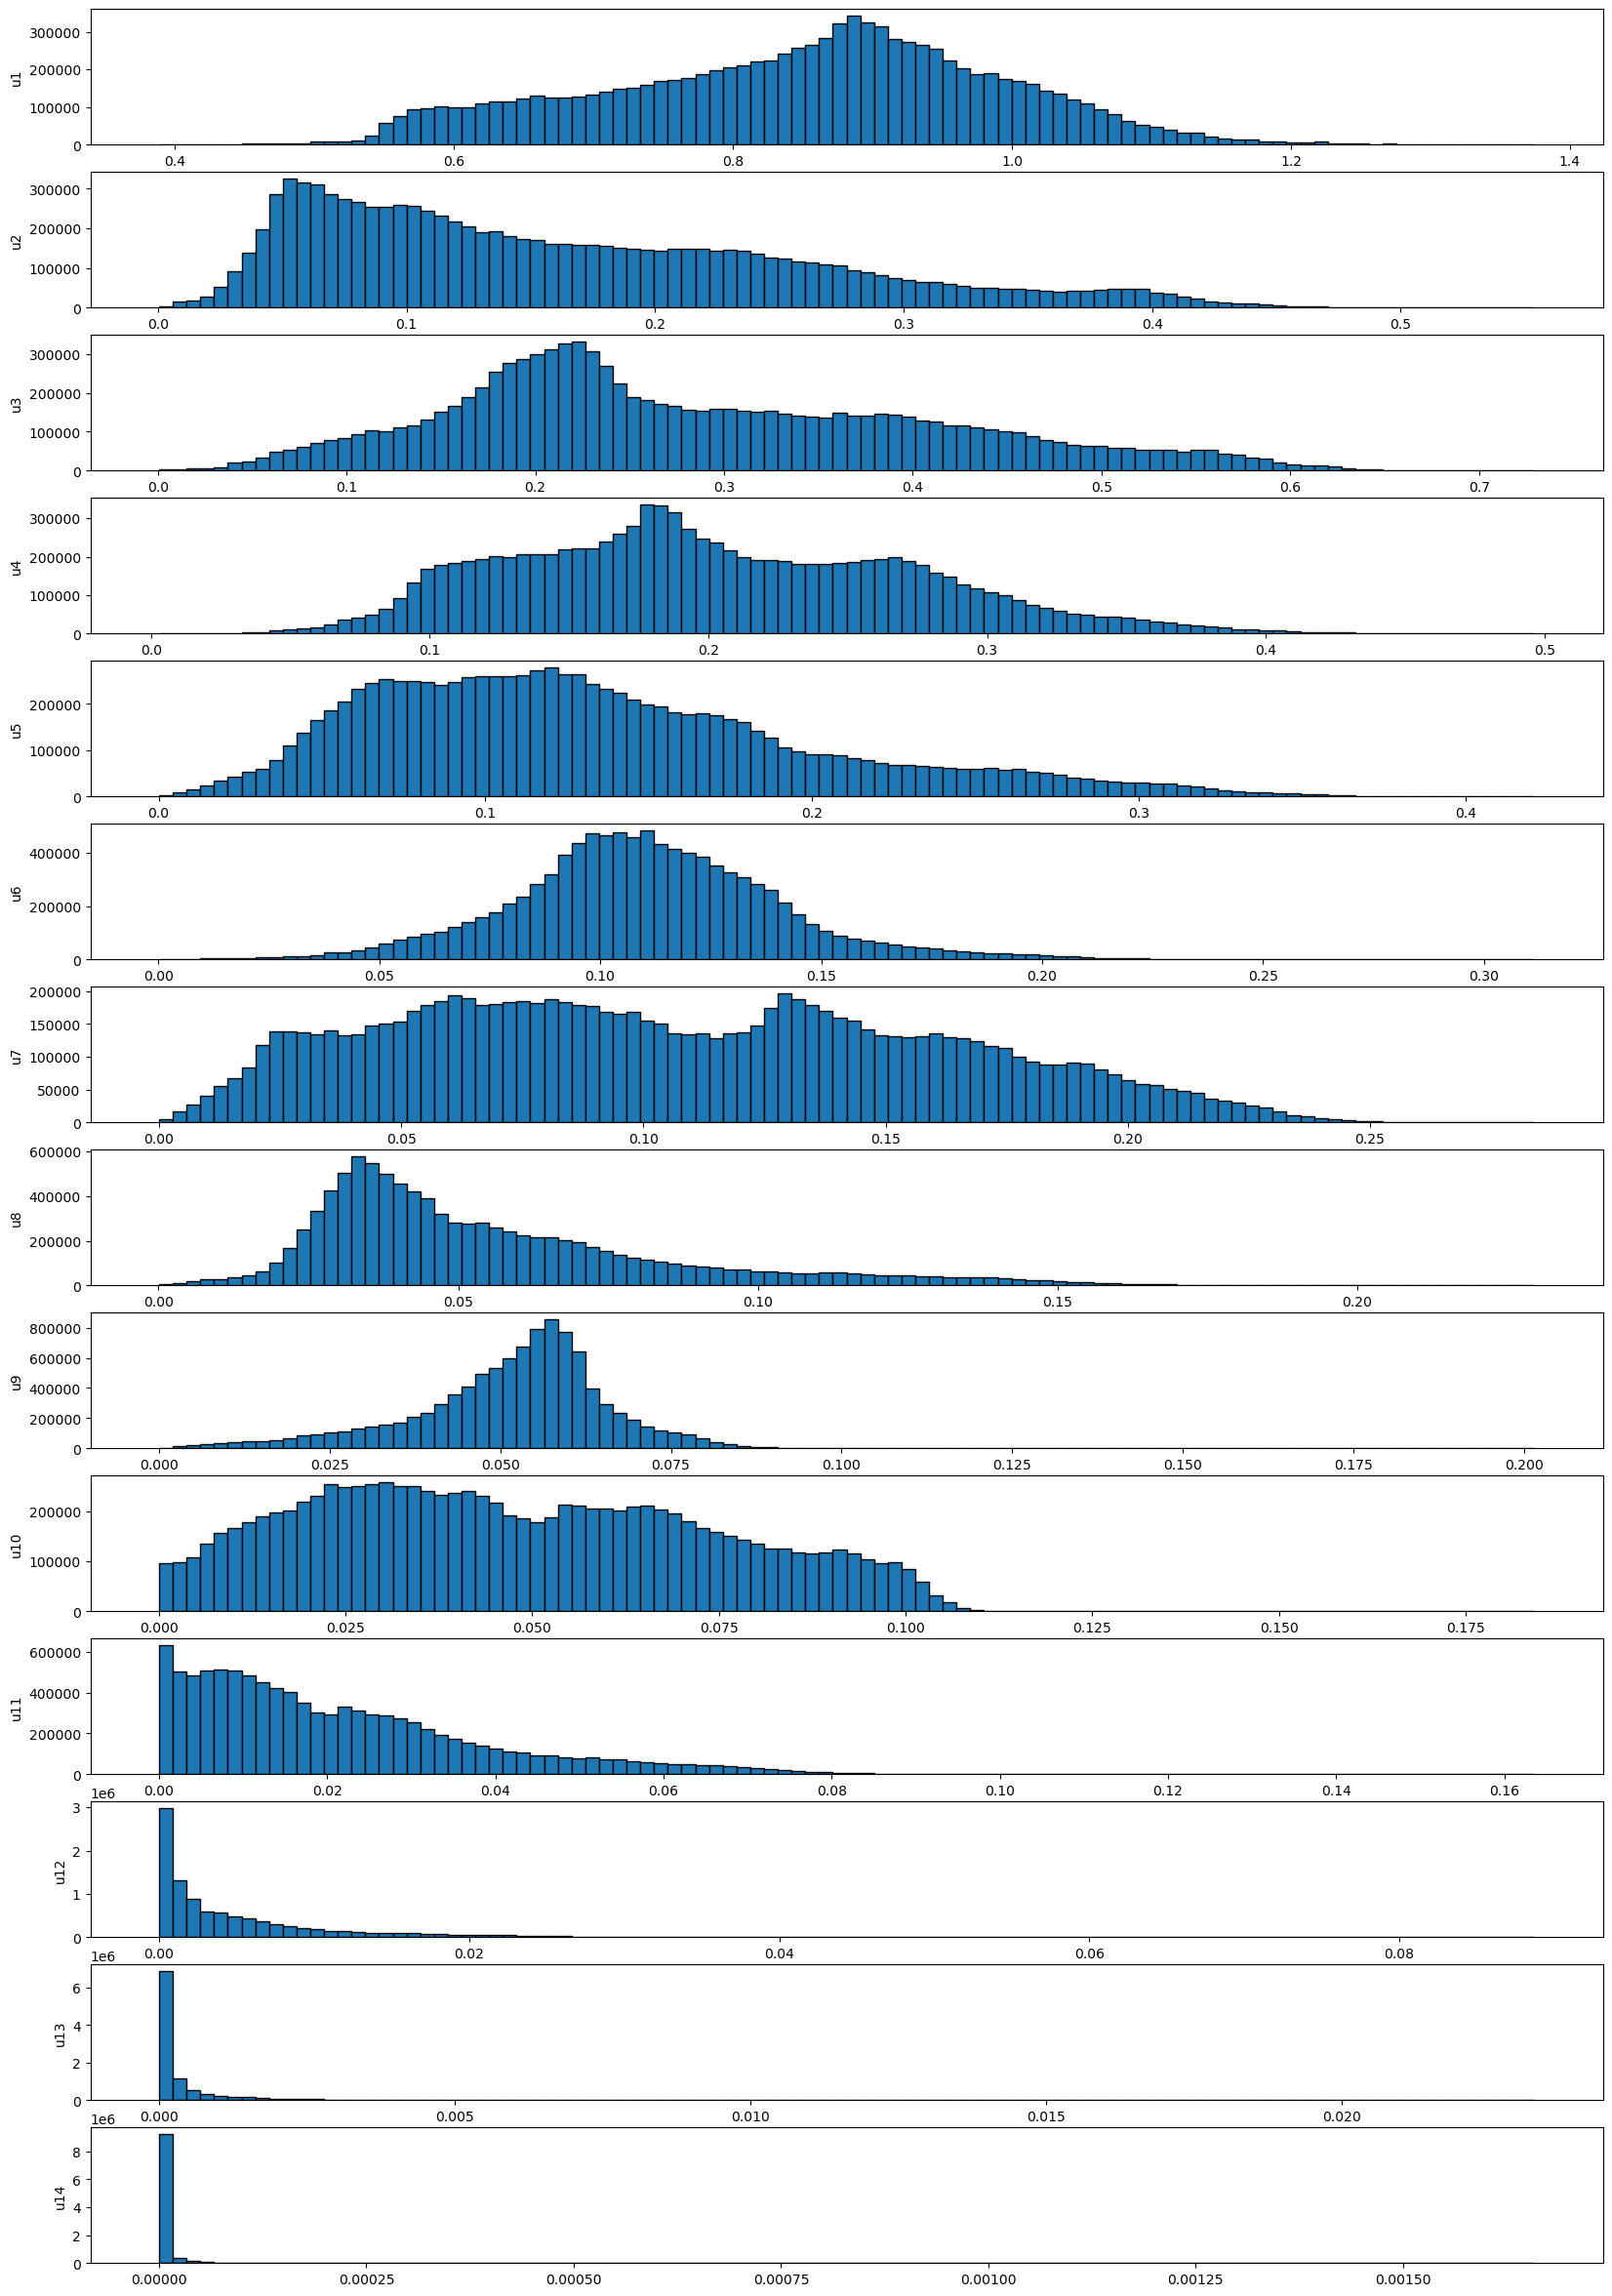

In [5]:
runge_para["period"]=(0,100000)
runge_para['start'] = np.load("/Users/hibiki/Downloads/beta0.417_nu0.00017632638671047897_step0.01_1500check_500pro_20000period.npz")["laminar"][:-1,:1]
runge_para["nu"] = 0.0001763
beta= 0.417

#c_n_2
runge_para["c_n_2"] = runge_para["k_n"][1:-3, 0:] * -beta
runge_para["c_n_2"][-1, 0:] = np.zeros((1, 1))

#c_n_3
runge_para["c_n_3"] = runge_para["k_n"][:-4, 0:] * (beta - 1)
model = RungeKutta_acceralated.RungeKutta()
model.get_arr_latter(**runge_para, latter=1)

plt.figure(figsize=(20,30))
for i in range(model.arr_latter.shape[0]-1):
    plt.subplot(model.arr_latter.shape[0]-1,1,i+1)
    plt.ylabel(f"u{i+1}")
    plt.hist(abs(model.arr_latter[i, :]), bins=100, edgecolor='black')
#plt.subplot(Dimention,1,1)

In [11]:
stats.mode(abs(model.arr_latter[0,:]), keepdims=True)

ModeResult(mode=array([0.38855]), count=array([1]))